# Static Structure Factor

The `freud.diffraction` module provides two methods for calculating a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) S(q) which can be used to characterise structure of crystals, liquids or amorphous phases.

Freud implements both a "direct" $S(q)$ method, which operates on a k-space histogram, and a method based on the Debye scattering formula, which provides a much faster algorithm but gives worse results than the "direct" method at low-k values. Both methods support $S(q)$ calulation over a single simulation trajectory frame, and over a single simulation frame.


The examples shown here use points that were generated from a HOOMD-blue simulation of a 1000-particle system subject to the Lennard-Jones potential. For a tutorial of how to run such a simulation, see 00-Introducing-HOOMD-blue in Glotzerlab's [hoomd-examples repository](https://github.com/glotzerlab/hoomd-examples).

## freud.diffraction.StaticStructureFactorDebye

The `freud.diffraction.StaticStructureFactorDebye` class computes a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) for a set of $N$ points, based on the Debye scattering equation:

$$ S(\mathbf{q}) = {\frac{1}{N}} \sum_{j=1}^{N}\sum_{k=1}^{N}{\frac{\sin(qr_{jk})}{qr_{jk}}}$$

In [1]:
# Read in the simulation data
import gsd.hoomd

traj = gsd.hoomd.open("../data/LJsampletraj.gsd", "rb")

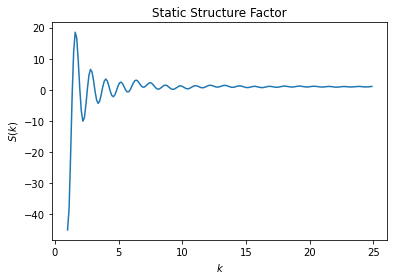

In [7]:
import freud
import matplotlib.pyplot as plt

# Retrieve system data from the final trajectory frame
snapshot = traj[-1]
box = snapshot.configuration.box
points = snapshot.particles.position

sfDebye = freud.diffraction.StaticStructureFactorDebye(bins=200, k_max=25, k_min=1)
sfDebye.compute((box, points))

sfDebye.plot()
plt.show()

Alternatively, to compute $S(q)$ over an entire trajectory, call `compute()` with `reset=False`:# Accumulate S(q) over the entire trajectory

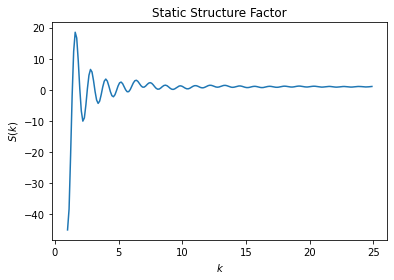

In [8]:
sfDebyeIterated = freud.diffraction.StaticStructureFactorDebye(bins=200, k_max=25, k_min=1)

for frame in traj:
    box = frame.configuration.box
    points = frame.particles.position
    
    sfDebyeIterated.compute((box, points), reset=False)
    
sfDebyeIterated.plot()
plt.show()

## freud.diffraction.StaticStructureFactorDirect

The `freud.diffraction.StaticStructureFactorDirect` class computes a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) for a set of N points:

$$S(\mathbf{q}) = {\frac{1}{N}}\sum_{j=1}^{N}\sum_{k=1}^{N}\mathrm{e}^{-i\mathbf{q}\cdot(\mathbf{R}_{j} - \mathbf{R}_{k})}$$

In [9]:
# Read in the simulation data
import gsd.hoomd

traj = gsd.hoomd.open("../data/LJsampletraj.gsd", "rb")

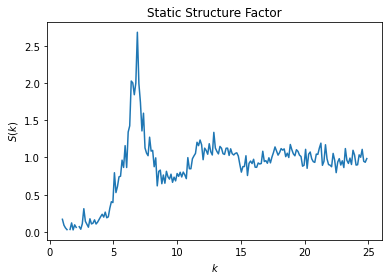

In [11]:
import freud
import matplotlib.pyplot as plt

snapshot = traj[-1]
box = snapshot.configuration.box
points = snapshot.particles.position

sfDirect = freud.diffraction.StaticStructureFactorDirect(bins=200, k_max=25, k_min=1)
sfDirect.compute((box, points))

sfDirect.plot()
plt.show()

Alternatively, to compute $S(q)$ over an entire trajectory, call `compute()` with `reset=False`:

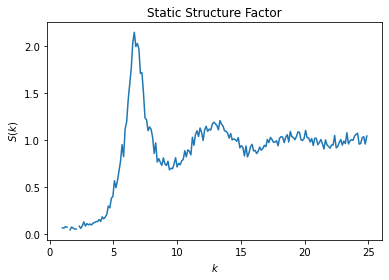

In [12]:
sfDirectIterated = freud.diffraction.StaticStructureFactorDirect(bins=200, k_max=25, k_min=1)

# Accumulate S(q) over the entire trajectory
for frame in traj:
    box = frame.configuration.box
    points = frame.particles.position
    
    sfDirectIterated.compute((box, points), reset=False)
    
sfDirectIterated.plot()
plt.show()

Both `freud.diffraction.StaticStructureFactorDirect` and `freud.diffraction.StaticStructureFactorDebye` classes support calculation of partial structure factors according to Faber-Ziman decomposition [link to docs??]. In this example we randomly split the system in two parts, one containing a third of the system and the other one containing the other two thirds of the system. The calculation of the partials requires the usage of nquery and N_tot to be sucessfull:

# freud.diffraction.StaticStructureFactorDirect

The `freud.diffraction.StaticStructureFactorDirect` class computes a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) $S(k)$ of a set of points. For an excellent introduction to the theory of scattering and $S(k)$, please refer to the documentation of the [dynasor package](https://dynasor.materialsmodeling.org/), which performs a number of calculations related to scattering. We have re-implemented the core method of static structure factor calculation from dynasor in **freud** with some additional performance optimizations in parallelized C++ code, as well as an interface to compute $S(k)$ that aligns with the APIs and conventions of the **freud** analysis library.

In [ ]:
L = 10
N = 10000
max_k_points = 200000
box, points = freud.data.make_random_system(L, N)
system = freud.AABBQuery.from_system((box, points))
A_points = system.points[: N // 3]
B_points = system.points[N // 3 :]
sf = freud.diffraction.StaticStructureFactorDirect(
    bins=100, k_max=100, k_min=1, max_k_points=max_k_points
)
sf.compute((system.box, B_points), query_points=A_points, N_total=N)
sf.plot()
plt.show()